In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

# Draw test points on left image

[[338 197   1]
 [468 290   1]
 [253 170   1]
 [263 256   1]
 [242 136   1]]


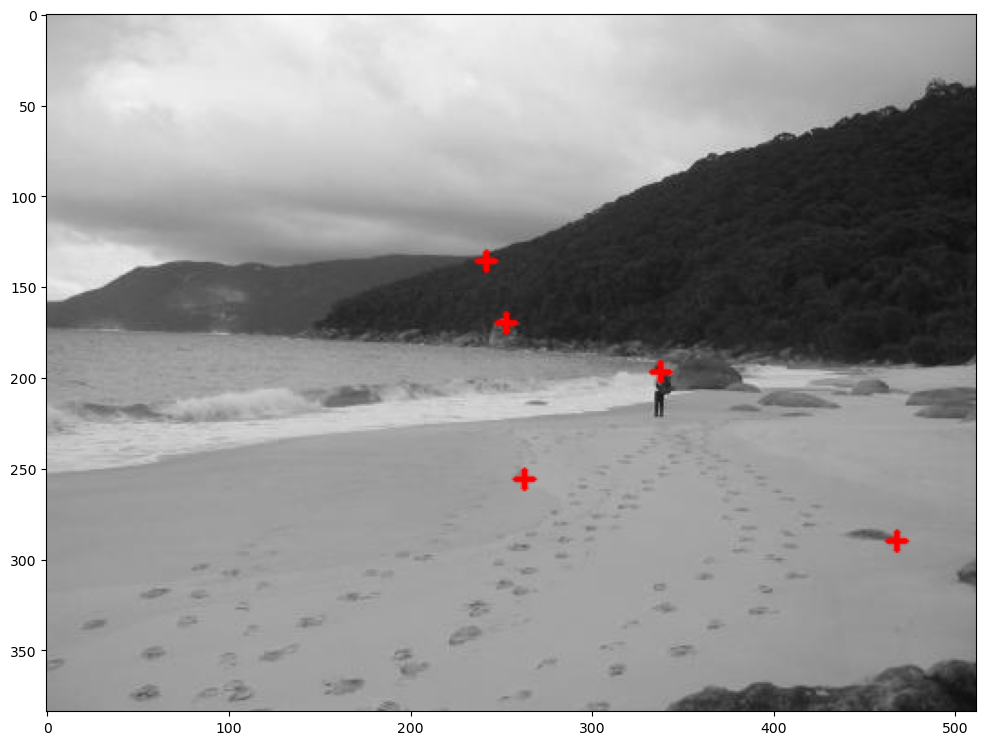

In [2]:
img_L = cv2.imread('left.jpg')
coord = np.array([[338,197,1],[468,290,1],[253,170,1],[263,256,1],[242,136,1]])
print(coord)

for i in range(len(coord)):
    h, w = coord[i][0], coord[i][1]
    cv2.drawMarker(img_L, (h,w),(255,0,0),markerType=cv2.MARKER_CROSS
    ,markerSize=10, thickness=2, line_type=cv2.LINE_AA)

figure(figsize=(12,10))
plt.imshow(img_L) 



 What makes a coordinate homogenous ?

A homogenenous coordinate is a coordinate system that algebraically treats all points in the projective plane equally. A coordinate is homogenous if x = ax where a ~= 0 and it can be used to represent points at infinity with a finite coordinates. For example if we have a matrix x = [5 10] in euclidean plane and the homogenous coordinate of this is x = [5 10 1], so we add another dimension in our matrix. The points at infinity of our matrix 
will be equal to x = [5 10 0], this is a point at infinity because with this matrix if we want to go back to the euclidean coordinate, we would divide everything with the last element which is zero and any value divided  by zero is equal to infinity

# Use homography to find right image points

[[142.66555052 211.77073075   1.        ]
 [261.83873366 298.43101419   1.        ]
 [ 56.03915004 184.68092375   1.        ]
 [ 64.90473276 274.29144567   1.        ]
 [ 44.93983103 148.90246583   1.        ]]


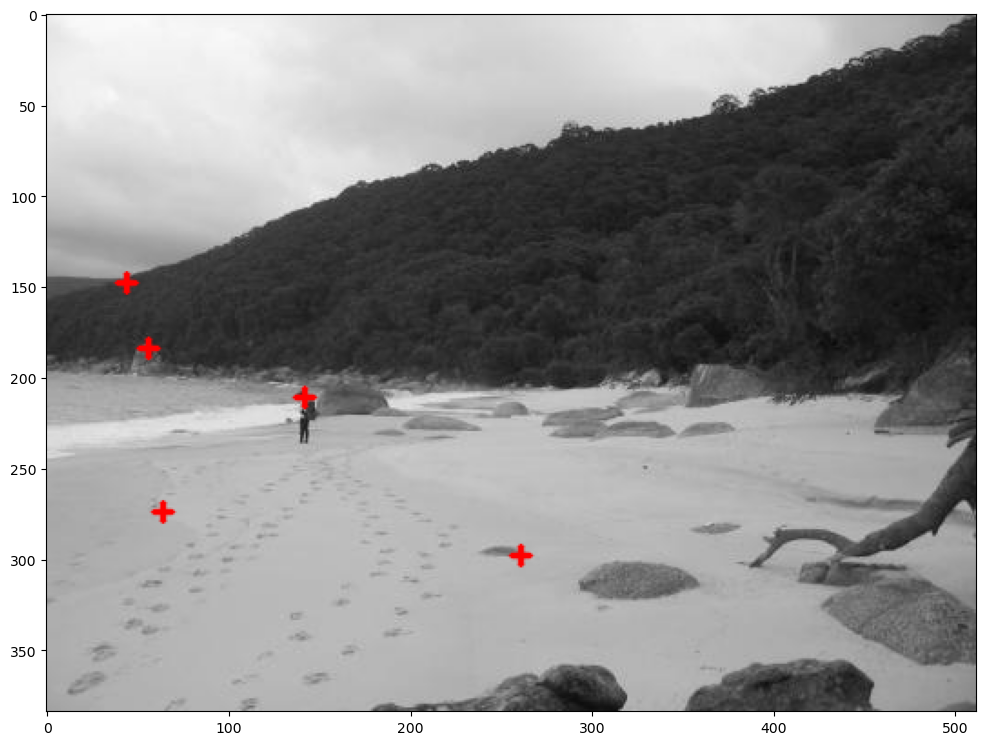

In [3]:
img_R = cv2.imread('right.jpg')

H = np.array([[1.6010, -0.0300, -317.9341], [0.1279, 1.5325, -22.5847], [0.0007, 0, 1.2865]])
xr = np.dot(H, np.transpose(coord))
xr = np.transpose(xr)

for i in range(len(xr)):
    xr[i][0] = xr[i][0] / xr[i][2]
    xr[i][1] = xr[i][1] / xr[i][2]
    xr[i][2] = xr[i][2] / xr[i][2]


for i in range(len(xr)):
    
    h, w = int(xr[i][0]), int(xr[i][1])
    cv2.drawMarker(img_R, (h,w),(255,0,0),markerType=cv2.MARKER_CROSS
    ,markerSize=10, thickness=2, line_type=cv2.LINE_AA)

print(xr)

figure(figsize=(12,10))
plt.imshow(img_R) 


How do you reverse a homography operation ?

We can reverse the homography operation by dividing our array with the last element and this will make our extra dimension equals to 1 for each channel. Then we can just delete the last element or the added dimension in our array. So for example we have a homogenous coordinates equal to x = [6, 12, 3] after dividing we'll get x = [2, 4, 1] and the last step is deleting the extra dimension, which will give us x = [2, 4]. This is our coordinates in the euclidean plane.

# Billinear interpolation to the right image

In [4]:
def interp(im,x,y): # a function to interpolate the image pixel value at coordinates x,y
    # this is all the intensity of the 4 points surrounding the current pixel location
    x1 = int(np.floor(x))
    x2 = int(np.ceil(x))
    y1 = int(np.floor(y))
    y2 = int(np.ceil(y)) 
    Q11 = im[x1,y1,0] 
    Q12 = im[x1,y2,0]
    Q21 = im[x2,y1,0]
    Q22 = im[x2,y2,0]
    # x-direction
    R1 = Q11 * ((x2-x)/(x2-x1)) + Q21 * ((x-x1)/(x2-x1))
    R2 = Q12 * ((x2-x)/(x2-x1)) + Q22 * ((x-x1)/(x2-x1))
    # y-direction
    result = R1 * ((y2-y)/(y2-y1)) + R2 * ((y-y1)/(y2-y1))
    
    return result

img_L = cv2.imread('left.jpg')
img_R = cv2.imread('right.jpg')

test_points = []

for i in range(len(xr)):
    test_points.append(interp(img_R, xr[i][1], xr[i][0]))

print(test_points)

[118.52244596111441, 180.0533033498499, 83.51462546797471, 186.41710866313065, 49.87780754172684]


Explain why we need bilinear interpolation ?

The bilinear interpolation is used to resample the images and the textures that comes with it. So to find the pixel location we use homography and to get the intensity of the pixel we use interpolation. It gaves a really good results because it measures the weighted average of the attributes of 4 surrounding pixels and apply it to the current pixel location. We keep on doing this with every pixel location to interpolate the right image into the left image.

# Image Stitching

In [5]:
# Used the left image for width 0 to 512 of the final image and used the stitched image for 
# the rest of the width of final image
img_L = cv2.imread('left.jpg')
img_R = cv2.imread('right.jpg')

final_img =  np.zeros((384,1024)) # this will be the array for the final stitched image

# For transformation we need the homography points from before
H = np.array([[1.6010, -0.0300, -317.9341], [0.1279, 1.5325, -22.5847], [0.0007, 0, 1.2865]])

new_coords = [] # this is used to get the coordinates that will be used in the right image
h, w, ch = img_R.shape # we use shape to get the height and width of our right image

for i in range(len(final_img)): # iterate through each channel 
    for j in range(len(final_img[i])): # iterate through the x and y coordinates in each channel 
        if j < 512: # So fill the left part of final_img with the img_L for width 0 to 512
            final_img[i,j] = img_L[i,j,0]
        else: # After that stitched the right image to the final_img image
            new_coords = np.matmul(H, [j,i,1]) # This the coordinates from our left image to get the 
                                               # corresponding coordinates in the right image. Just 
                                               # like what we did before.
                    
            new_coords = new_coords / new_coords[-1] # making the coordinates into homogenous coordinates for example
            # x = [178 156 1] by dividing with the last element
            
            # After doing the operation, we got a negative value and therefore we want to ignore these coordinates
            # since it is an invalid coordinates and make the pixel value equals to zero as seen in the code below
            if new_coords[0] < 0 or new_coords[1] < 0:
                final_img[i,j] = img_L[i,j,0] 
            elif 0 < new_coords[0] < (w - 1)  and 0 < new_coords[1] < (h - 1):
            # If it is a valid coordinate that exist in the right image we take the pixel value by using the 
            # Bilinear Interpolation function from before.
                pxl = interp(img_R,new_coords[1],new_coords[0])
                final_img[i,j] = pxl
        

filename = "Stitched_img.jpg"
cv2.imwrite(filename, final_img)
# Save The image into a file because if final_img plotted directly, we could got some white spots in the final_img. it 
# was somehow fixed by saving it into a file, then extract and plot it

/var/folders/db/96q4k_9n5s9fk3my0k61nlhr0000gn/T/ipykernel_2724/164910162.py:12: RuntimeWarning: invalid value encountered in double_scalars
  R1 = Q11 * ((x2-x)/(x2-x1)) + Q21 * ((x-x1)/(x2-x1))
/var/folders/db/96q4k_9n5s9fk3my0k61nlhr0000gn/T/ipykernel_2724/164910162.py:13: RuntimeWarning: invalid value encountered in double_scalars
  R2 = Q12 * ((x2-x)/(x2-x1)) + Q22 * ((x-x1)/(x2-x1))
/var/folders/db/96q4k_9n5s9fk3my0k61nlhr0000gn/T/ipykernel_2724/164910162.py:15: RuntimeWarning: invalid value encountered in double_scalars
  result = R1 * ((y2-y)/(y2-y1)) + R2 * ((y-y1)/(y2-y1))


True

Why is there an obvious stitch in the image ?
The stitch is still visible because the difference in brightness, texture and the contrast between the two images is quite large. Also, the seam is visible because the pixel intensity value of the left image and the right image overlap at that specific coordinates.

# Final Result

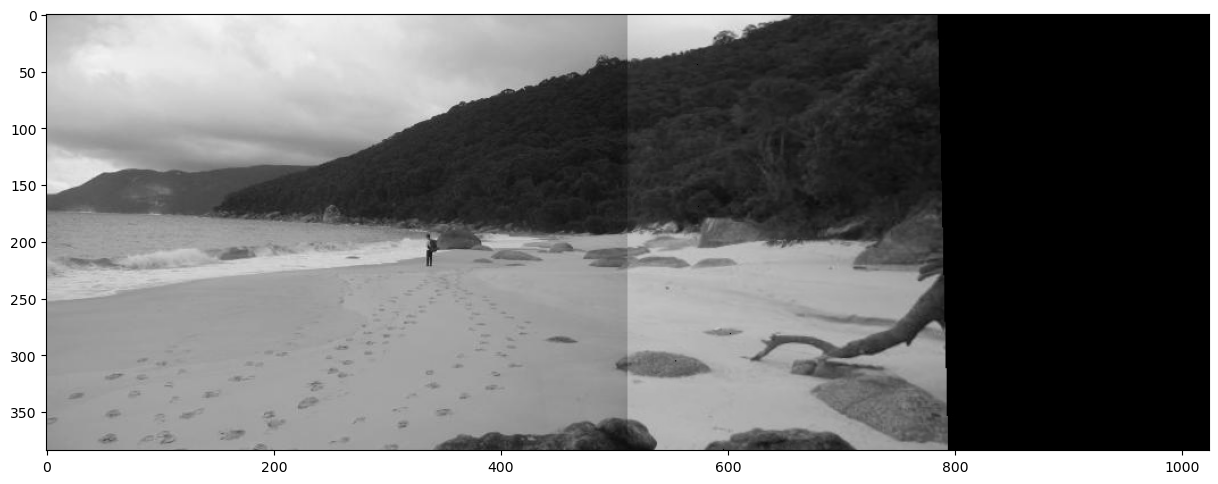

In [6]:
final_img = cv2.imread('Stitched_img.jpg')
figure(figsize = (15,10))
plt.imshow(final_img, cmap='gray')

# Improve Blending

# Removing black pixels

True

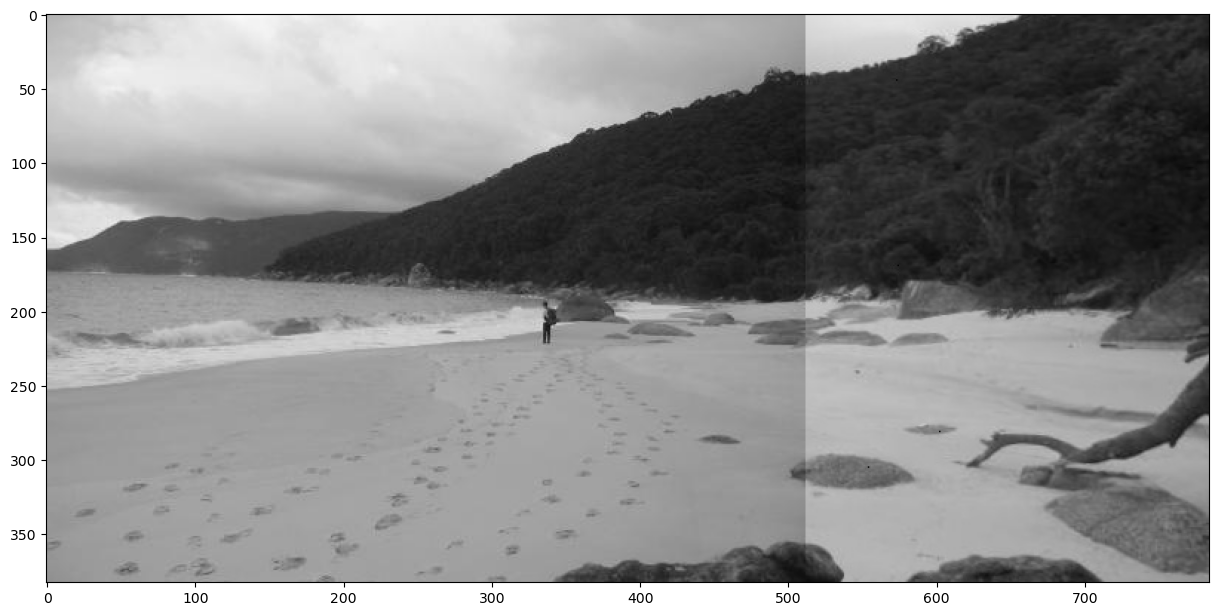

In [7]:
final_img = cv2.imread('Stitched_img.jpg')

# remove_black_pixels function checks the nonzero values in the channels and delete all the zero values in the
# final_img array. Return the minimum and maximum of the nonzero values for the range of values for the final_img.
def remove_black_pixels(image):
    y_nonzero, x_nonzero, _ = np.nonzero(image)
    return image[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):(np.max(x_nonzero) - 15)]

final_img = remove_black_pixels(final_img)
figure(figsize = (15,10))
plt.imshow(final_img, cmap='gray')

filename = "Stitched_img.jpg"
cv2.imwrite(filename, final_img)


# Adjusting Brightness

In [8]:
def change_brightness(img, value):
    # hsv is just the image in a format where each channel shows us the shade of the colors in that specific pixel
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v,value) 
    # the value from the argument is used as the factor for how much we want to reduce or increase the value 
    # of the color for that pixel
    v[v > 255] = 255 # if the addition is greater than 255 we just make it into 255 since values for RGB has 
                     # a maximum value of 255
    v[v < 0] = 0 # RGB values cannot be negative so if its less than that I make it to zero
    final_hsv = cv2.merge((h, s, v)) # merge the hue, saturation and the value which is the height of 
                                     # the "color cone" 
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

img_L = cv2.imread('left.jpg')
img_L = change_brightness(img_L, value=32) # the value is chosen by trial and error because we can see that the 
                                           # left image is way darker than the right image. So we just adjust the 
                                           # brightness of the left one
img_R = cv2.imread('right.jpg')


final_img =  np.zeros((384,1024))

# For transformation we need the homography points 
H = np.array([[1.6010, -0.0300, -317.9341], [0.1279, 1.5325, -22.5847], [0.0007, 0, 1.2865]])

new_coords = []
h, w, ch = img_R.shape

for i in range(len(final_img)):
    for j in range(len(final_img[i])):
        if j < 512:
            final_img[i,j] = img_L[i,j,0]
        else:
            new_coords = np.matmul(H, [j,i,1])
            new_coords = new_coords / new_coords[-1]
        
            if new_coords[0] < 0 or new_coords[1] < 0:
                final_img[i,j] = img_L[i,j,0] 
            elif 0 < new_coords[0] < (w - 1)  and 0 < new_coords[1] < (h - 1):
                pxl = interp(img_R,new_coords[1],new_coords[0])
                final_img[i,j] = pxl
                
filename = "Stitched_Image_Adjust_Brightness.jpg"
cv2.imwrite(filename, final_img)
# I save my image into a file because if I plot the final_img directly, I got some white spots in the final_img. it 
# was somehow fixed by saving it into a file, then extract and plot it

# Code from REMOVING BLACK PIXELS                
final_img = cv2.imread('Stitched_Image_Adjust_Brightness.jpg')
final_img = remove_black_pixels(final_img)

cv2.imwrite(filename, final_img)

/var/folders/db/96q4k_9n5s9fk3my0k61nlhr0000gn/T/ipykernel_2724/164910162.py:12: RuntimeWarning: invalid value encountered in double_scalars
  R1 = Q11 * ((x2-x)/(x2-x1)) + Q21 * ((x-x1)/(x2-x1))
/var/folders/db/96q4k_9n5s9fk3my0k61nlhr0000gn/T/ipykernel_2724/164910162.py:13: RuntimeWarning: invalid value encountered in double_scalars
  R2 = Q12 * ((x2-x)/(x2-x1)) + Q22 * ((x-x1)/(x2-x1))
/var/folders/db/96q4k_9n5s9fk3my0k61nlhr0000gn/T/ipykernel_2724/164910162.py:15: RuntimeWarning: invalid value encountered in double_scalars
  result = R1 * ((y2-y)/(y2-y1)) + R2 * ((y-y1)/(y2-y1))


True

# Result after brightness has been adjusted

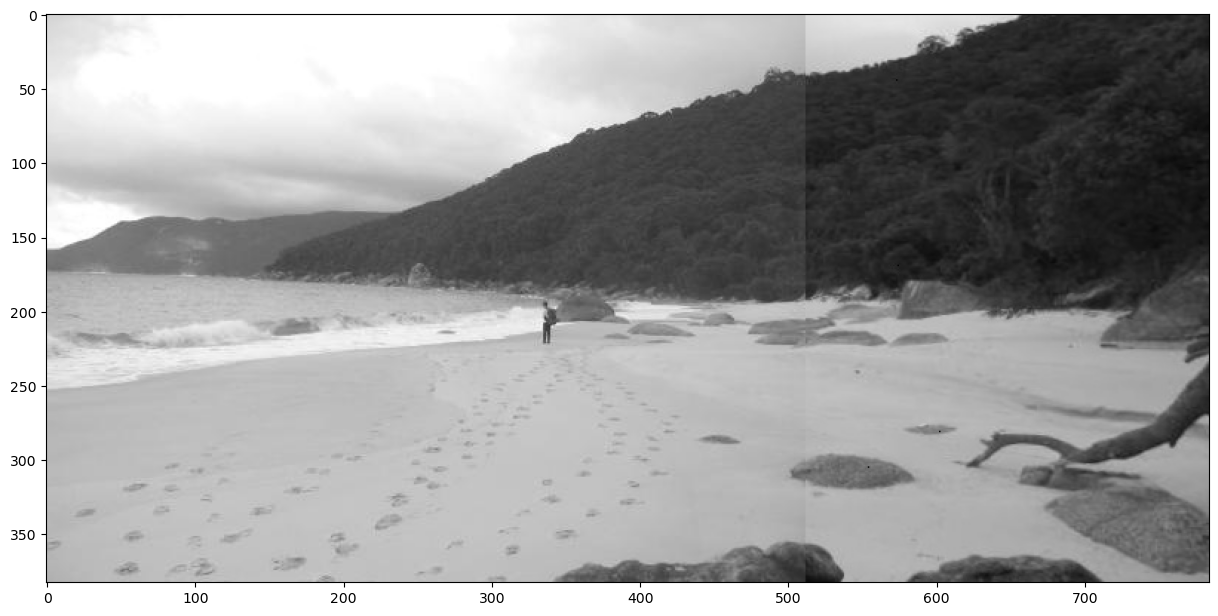

In [9]:
figure(figsize = (15,10))
plt.imshow(final_img, cmap='gray')

# Adding Gaussian Blur

In [10]:
for i in range(len(final_img)):
    for j in range(len(final_img[i])):
        if j > 462 and j < 562: 
            # I applied the gaussian blur in between the width where the seam is visible to reduce 
            # the visibility of the seam itself.
            temp = cv2.GaussianBlur(final_img[i][j],(5,5),cv2.BORDER_DEFAULT)
            temp = np.transpose(temp)
            final_img[i][j] = temp


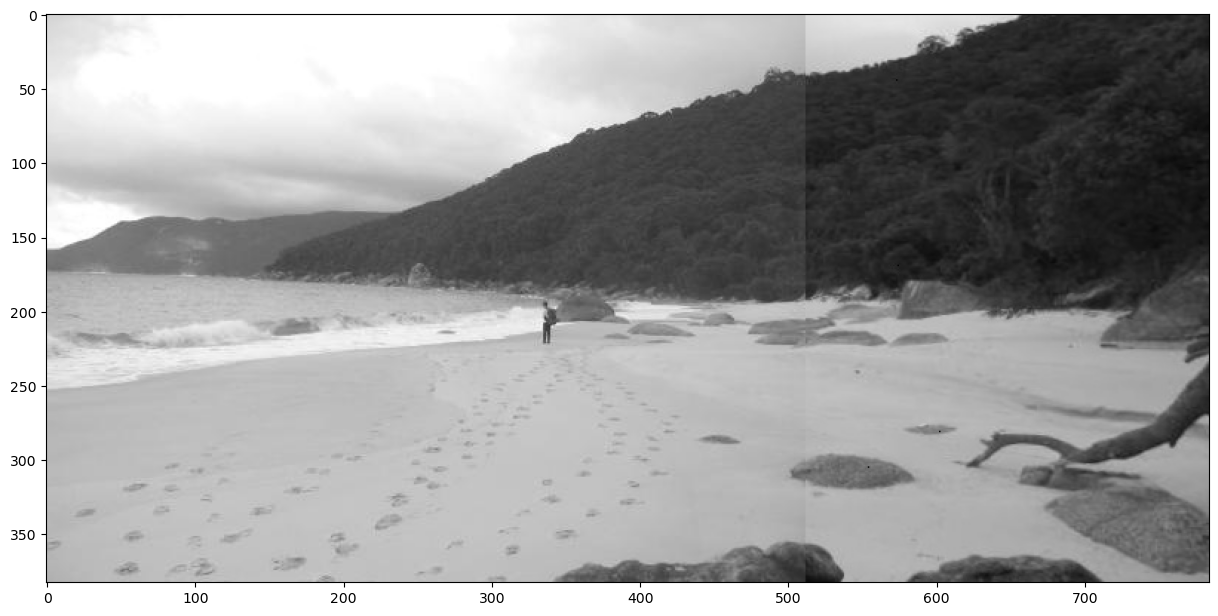

In [11]:
figure(figsize = (15,10))
plt.imshow(final_img, cmap='gray')
